<a href="https://colab.research.google.com/github/ReAlex1902/Pneumonia_Detection/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run next scripts in colab to download data

In [2]:
!pip install kaggle

In [8]:
## upload your kaggle.json

from google.colab import files
files.upload()

{}

In [9]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

 98% 1.17G/1.19G [00:14<00:00, 42.2MB/s]
100% 1.19G/1.19G [00:14<00:00, 87.5MB/s]


In [11]:
# Downloading dataset:
from zipfile import ZipFile
import os
import pandas as pd

# # The below code is ran in google colab
# os.environ["KAGGLE_USERNAME"] = "KAGGLE_USERNAME"  # username from the json file
# os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"  # key from the json file
# !kaggle datasets download -d praveengovi/coronahack-chest-xraydataset  # api copied from kaggle

# Create a ZipFile Object and load chest-xray-pneumonia.zip in it
with ZipFile("/content/coronahack-chest-xraydataset.zip", "r") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

# KAGGLE LINK: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

# Import necessary libs

In [12]:
import os
import torch
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import models, transforms
from tqdm import tqdm_notebook
from PIL import Image

%matplotlib inline

# Implementing code to get data

In [13]:
DATA_INFO_PATH = os.path.join('Chest_xray_Corona_Metadata.csv')
TRAIN_FOLDER = os.path.join('Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')    
TEST_FOLDER = os.path.join('Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')

In [14]:
data = pd.read_csv(DATA_INFO_PATH, index_col = 0)

In [15]:
data.sample(frac = 1).head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
4510,person700_bacteria_2599.jpeg,Pnemonia,TRAIN,NaN,bacteria
3674,person447_virus_921_1.jpeg,Pnemonia,TRAIN,NaN,Virus
4272,person571_virus_1114.jpeg,Pnemonia,TRAIN,NaN,Virus
2412,person1463_bacteria_3811.jpeg,Pnemonia,TRAIN,NaN,bacteria
2357,person1483_bacteria_3876.jpeg,Pnemonia,TRAIN,NaN,bacteria


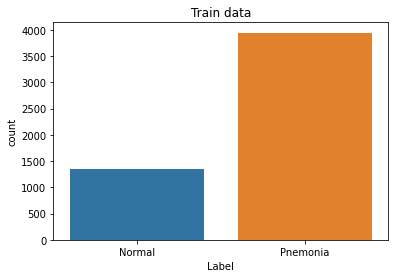

In [16]:
sns.countplot(data = data[data['Dataset_type'] == 'TRAIN'], x = 'Label');
plt.title("Train data");

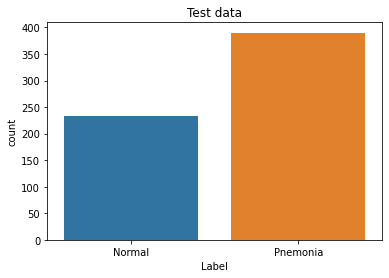

In [17]:
sns.countplot(data = data[data['Dataset_type'] == 'TEST'], x = 'Label');
plt.title("Test data");

## Dataset class

person502_bacteria_2121.jpeg
Label = Pnemonia
Shape: (808, 1096, 3)

person488_bacteria_2062.jpeg
Label = Pnemonia
Shape: (1156, 1704, 3)

NORMAL2-IM-0948-0001.jpeg
Label = Normal
Shape: (1839, 1994, 3)

person600_virus_1156.jpeg
Label = Pnemonia
Shape: (548, 796, 3)

person1308_bacteria_3290.jpeg
Label = Pnemonia
Shape: (928, 1416, 3)



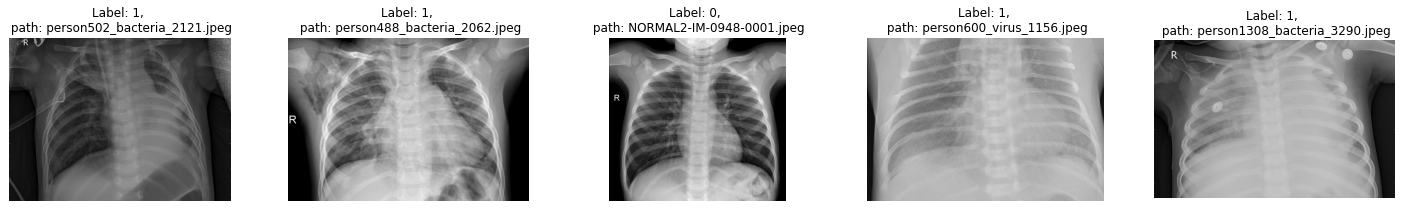

In [18]:
class Pneumonia_Dataset(Dataset):
    def __init__(self, csv_file, folder, transform = None):
        """
        csv_file (string) - scv file with metadata
        folder (string) - folder with images
        transform (callable, optional) - transform applied to the images, augmentation
        """
        self.csv_file = pd.read_csv(csv_file)
        self.folder = folder
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.folder))
    
    def __getitem__(self, index):
        image_name = os.listdir(self.folder)[index]
        image_path = os.path.join(self.folder, image_name)
        image = Image.open(image_path)
        image = image.convert('RGB')
        # image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ## We get the picture from folder by index, take its name and get the label from csv by name
        y = 1 if self.csv_file[self.csv_file['X_ray_image_name'] == image_name]['Label'].to_string().split()[1] == 'Pnemonia' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, y, image_path
    
def visualize_samples(dataset, indices, count = 5):
    # visualize random samples
    plt.figure(figsize=(count*5,3))
    display_indices = indices[:count]
       
    for i, index in enumerate(display_indices):    
        x, y, path = dataset[index]
        path = os.path.split(path)[-1]
        print(path)
        print(f"Label = {data[data['X_ray_image_name'] == path]['Label'].to_string().split()[1]}")
        print(f'Shape: {np.array(x).shape}')
        print()
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.title(f"Label: {y}, \n path: {path}")
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')       

orig_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER)
indices = np.random.choice(np.arange(len(orig_dataset)), 5, replace=False)

visualize_samples(orig_dataset, indices)

person502_bacteria_2121.jpeg
Label = Pnemonia
Shape: (808, 1096, 3)

person488_bacteria_2062.jpeg
Label = Pnemonia
Shape: (1156, 1704, 3)

NORMAL2-IM-0948-0001.jpeg
Label = Normal
Shape: (1839, 1994, 3)

person600_virus_1156.jpeg
Label = Pnemonia
Shape: (548, 796, 3)

person1308_bacteria_3290.jpeg
Label = Pnemonia
Shape: (928, 1416, 3)



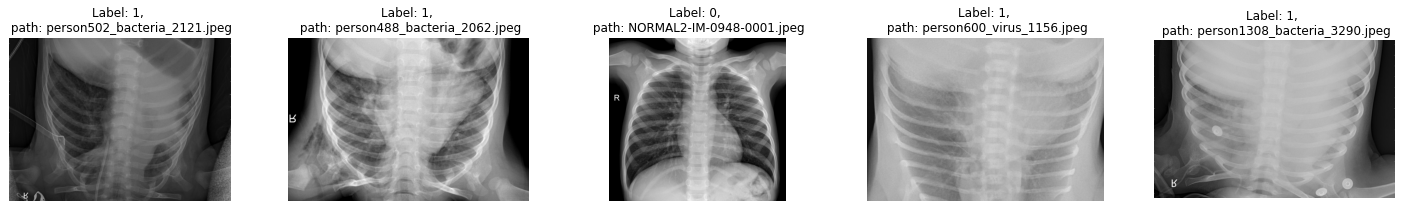

In [19]:
## Let's make sure transforms work!
## Samples with flip - a lot should be flipped!
dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER, transform=transforms.RandomVerticalFlip(0.9))
visualize_samples(dataset, indices)

#Find mean and std

In [20]:
def get_mean_std(loader):
    ## Var(x) = E(x**2) + (E(x))**2
    
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for x, y, _ in tqdm_notebook(loader):
        channels_sum += torch.mean(x, dim = [0, 2, 3])              ## 1 - number of channelse. There are always 3 channels
        channels_squared_sum += torch.mean(x**2, dim = [0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std


transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor()                      
            ])

dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER, transform = transform)
loader = DataLoader(dataset, batch_size = 64, shuffle = True)

mean, std = get_mean_std(loader)
print(f'Mean: {mean}')
print(f'Std: {std}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Mean: tensor([0.4833, 0.4833, 0.4833])
Std: tensor([0.2366, 0.2366, 0.2366])


## Creating our dataset for training and testing

In [21]:
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    # Use mean and std for pretrained models
                    # https://pytorch.org/docs/stable/torchvision/models.html
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])                         
            ])

train_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER, transform = transform)

test_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TEST_FOLDER, transform = transform)

In [22]:
len(train_dataset), len(test_dataset)

(5309, 624)

## Go to training

In [23]:
batch_size = 16

data_size = len(train_dataset)
validation_fraction = 0.3

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(11)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [24]:
## Let's use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [25]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y, _) in enumerate(train_loader):
                
            optimizer.zero_grad()
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        if scheduler:
            scheduler.step()
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    right = 0
    total = 0
    for batch in loader:
        x, y, _ = batch
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        preds = model(x_gpu)
        preds = torch.argmax(preds, axis = 1)
        right += torch.sum(preds == y_gpu)
        total += y_gpu.shape[0]
    return float(right) / total

In [26]:
torch.cuda.empty_cache() ## clear cache before training

# Evaluation and metrics

In [27]:
import sklearn.metrics as metrics

def evaluate_model(model, dataset):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    loader = torch.utils.data.DataLoader(dataset, batch_size = 1)
    ground_truth = []
    predictions = []

    for batch in loader:
        x, y, _ = batch
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        ground_truth.append(int(y_gpu))
        prediction = model(x_gpu)
        _, prediction = torch.max(prediction, axis = 1)    ## torch.max() returns (values, indices)
        predictions.append(int(prediction))
    
    return predictions, ground_truth

def binary_classification_metrics(model, prediction, ground_truth):
    precision = metrics.precision_score(prediction, ground_truth)
    recall = metrics.recall_score(prediction, ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    acc = compute_accuracy(model, test_loader)
    return precision, recall, f1, acc

#Custom model

In [26]:
import torch.nn as nn
import torch.optim as optim

# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

class Custom_model(nn.Module):
    def __init__(self):
        '''
        input - number of input features
        output - number of output features
        '''
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, 7),    ## 218x218x10
            nn.BatchNorm2d(10),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)         ## 109x109x10
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 24, 10),  ## 100x100x24
            nn.BatchNorm2d(24),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)         ## 50x50x24
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(24, 32, 5),  ## 46x46x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)         ## 23x23x32        
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 40, 4),  ## 20x20x40
            nn.BatchNorm2d(40),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)         ## 10x10x40      
        )
        self.layer5 = nn.Sequential(
            Flattener(),
            nn.Linear(10*10*40, 400),
            nn.ReLU(inplace = True),
            nn.Linear(400, 50),
            nn.ReLU(inplace = True),
            nn.Linear(50, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x 

In [40]:
custom_model = Custom_model()
custom_model.to(device)

EPOCHS = 5

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr = 0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50)
loss_history, train_history, val_history = train_model(custom_model, train_loader, val_loader, loss, optimizer, EPOCHS, scheduler)

Average loss: 0.430813, Train accuracy: 0.879450, Val accuracy: 0.909964
Average loss: 0.378326, Train accuracy: 0.933886, Val accuracy: 0.923338
Average loss: 0.370241, Train accuracy: 0.942739, Val accuracy: 0.947448
Average loss: 0.361332, Train accuracy: 0.951780, Val accuracy: 0.961575
Average loss: 0.360542, Train accuracy: 0.950273, Val accuracy: 0.928612


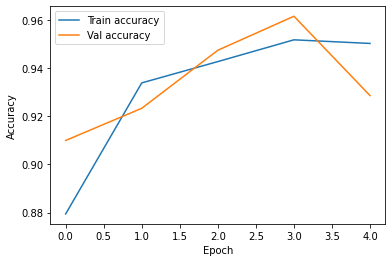

In [44]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

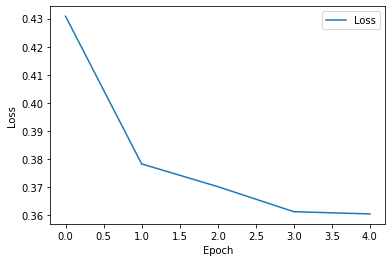

In [46]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [47]:
predictions, ground_truth = evaluate_model(custom_model, test_dataset)
precision, recall, f1, accuracy = binary_classification_metrics(custom_model, predictions, ground_truth)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.85
Precision = 0.94
Recall = 0.86
F1 = 0.9


#Densenet 201

In [33]:
import torch.nn as nn
import torch.optim as optim

densenet_model = models.densenet201(pretrained = True)
# for param in model.parameters():        ## freezing
#     param.requires_grad = False

in_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(in_features, 2)

densenet_model.to(device)
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# parameters = model.fc.parameters()
parameters = densenet_model.parameters()

EPOCHS = 9

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr = 0.00004)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50)
loss_history, train_history, val_history = train_model(densenet_model, train_loader, val_loader, loss, optimizer, EPOCHS, scheduler)

Average loss: 0.170764, Train accuracy: 0.930495, Val accuracy: 0.980034
Average loss: 0.087897, Train accuracy: 0.968921, Val accuracy: 0.983048
Average loss: 0.077261, Train accuracy: 0.973630, Val accuracy: 0.986438
Average loss: 0.060069, Train accuracy: 0.979092, Val accuracy: 0.986438
Average loss: 0.065908, Train accuracy: 0.977397, Val accuracy: 0.988322
Average loss: 0.048912, Train accuracy: 0.983801, Val accuracy: 0.991524
Average loss: 0.039006, Train accuracy: 0.985496, Val accuracy: 0.992277
Average loss: 0.043797, Train accuracy: 0.985685, Val accuracy: 0.994161
Average loss: 0.029381, Train accuracy: 0.989452, Val accuracy: 0.993596


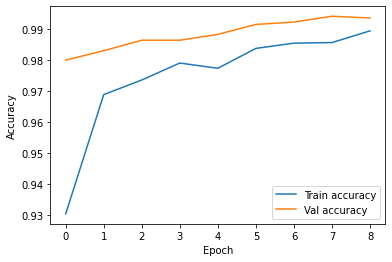

In [34]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

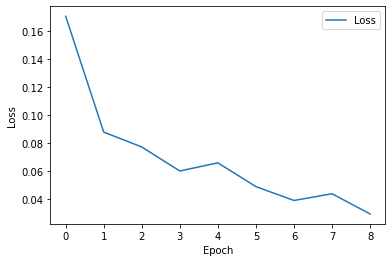

In [35]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [36]:
predictions, ground_truth = evaluate_model(densenet_model, test_dataset)
precision, recall, f1, accuracy = binary_classification_metrics(densenet_model, predictions, ground_truth)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.8
Precision = 0.99
Recall = 0.76
F1 = 0.86


#Resnet 152

In [71]:
resnet_model = models.resnet152(pretrained = True)
# for param in model.parameters():        ## freezing
#     param.requires_grad = False

in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, 2)

resnet_model.to(device)
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# parameters = resnet_model.fc.parameters()
parameters = resnet_model.parameters()

EPOCHS = 7

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr = 0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50)
loss_history, train_history, val_history = train_model(resnet_model, train_loader, val_loader, loss, optimizer, EPOCHS, scheduler)

Average loss: 0.156814, Train accuracy: 0.936523, Val accuracy: 0.964588
Average loss: 0.103415, Train accuracy: 0.958938, Val accuracy: 0.976832
Average loss: 0.092968, Train accuracy: 0.964777, Val accuracy: 0.974948
Average loss: 0.073484, Train accuracy: 0.975137, Val accuracy: 0.969486
Average loss: 0.063209, Train accuracy: 0.975702, Val accuracy: 0.978715
Average loss: 0.064762, Train accuracy: 0.976078, Val accuracy: 0.983801
Average loss: 0.058338, Train accuracy: 0.978715, Val accuracy: 0.988510


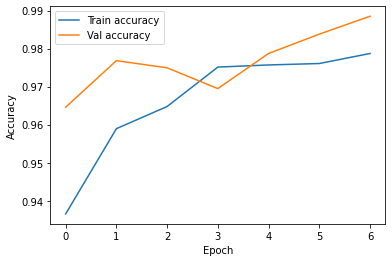

In [72]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_history, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_history, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

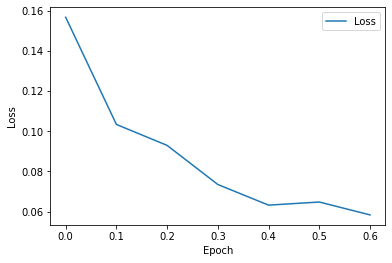

In [73]:
ax = sns.lineplot(x = [i*0.1 for i in range(EPOCHS)], y = loss_history, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [74]:
predictions, ground_truth = evaluate_model(resnet_model, test_dataset)
precision, recall, f1, accuracy = binary_classification_metrics(resnet_model, predictions, ground_truth)
print(f'Accuracy = {np.round(accuracy, 2)}')
print(f'Precision = {np.round(precision, 2)}')
print(f'Recall = {np.round(recall, 2)}')
print(f'F1 = {np.round(f1, 2)}')

Accuracy = 0.87
Precision = 0.99
Recall = 0.8
F1 = 0.88
